## Machine Learning: Profundización

![Colegio Bourbaki](./Images/Bourbaki.png)

### Dynamic Pricing

### Contexto

Una empresa de viajes compartidos quiere implantar una estrategia de precios dinámica para optimizar las tarifas en función de las condiciones del mercado en tiempo real. Actualmente, la empresa sólo utiliza la duración del trayecto para decidir las tarifas. La empresa quiere aprovechar las técnicas basadas en datos para analizar los datos históricos y desarrollar un modelo predictivo que pueda ajustar dinámicamente los precios en respuesta a factores cambiantes.

Se ha proporcionado un conjunto de datos que contiene datos históricos de viajes. El conjunto de datos incluye características como el número de pasajeros, el número de conductores, la categoría de ubicación, el estado de fidelidad del cliente, el número de trayectos anteriores, las valoraciones medias, la hora de la reserva, el tipo de vehículo, la duración prevista del trayecto y el coste histórico de los trayectos.

Su objetivo es construir un modelo de precios dinámico que incorpore las características proporcionadas para predecir las tarifas óptimas de los viajes en tiempo real. El modelo debe tener en cuenta factores como los patrones de demanda y la disponibilidad de la oferta.

Link: https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset?select=dynamic_pricing.csv

### Librerías

In [1]:
# Data Analysis
import pandas as pd

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch (DQN)
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import deque

# Utils
import numpy as np
import os
from tqdm.auto import trange

### Carga de Datos

In [2]:
df=pd.read_csv('./Data/dynamic_pricing.csv')

In [3]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


### Análisis Exploratorio

Vamos a ver la distribución de las variables numéricas y categóricas.

Primero, las numéricas:

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

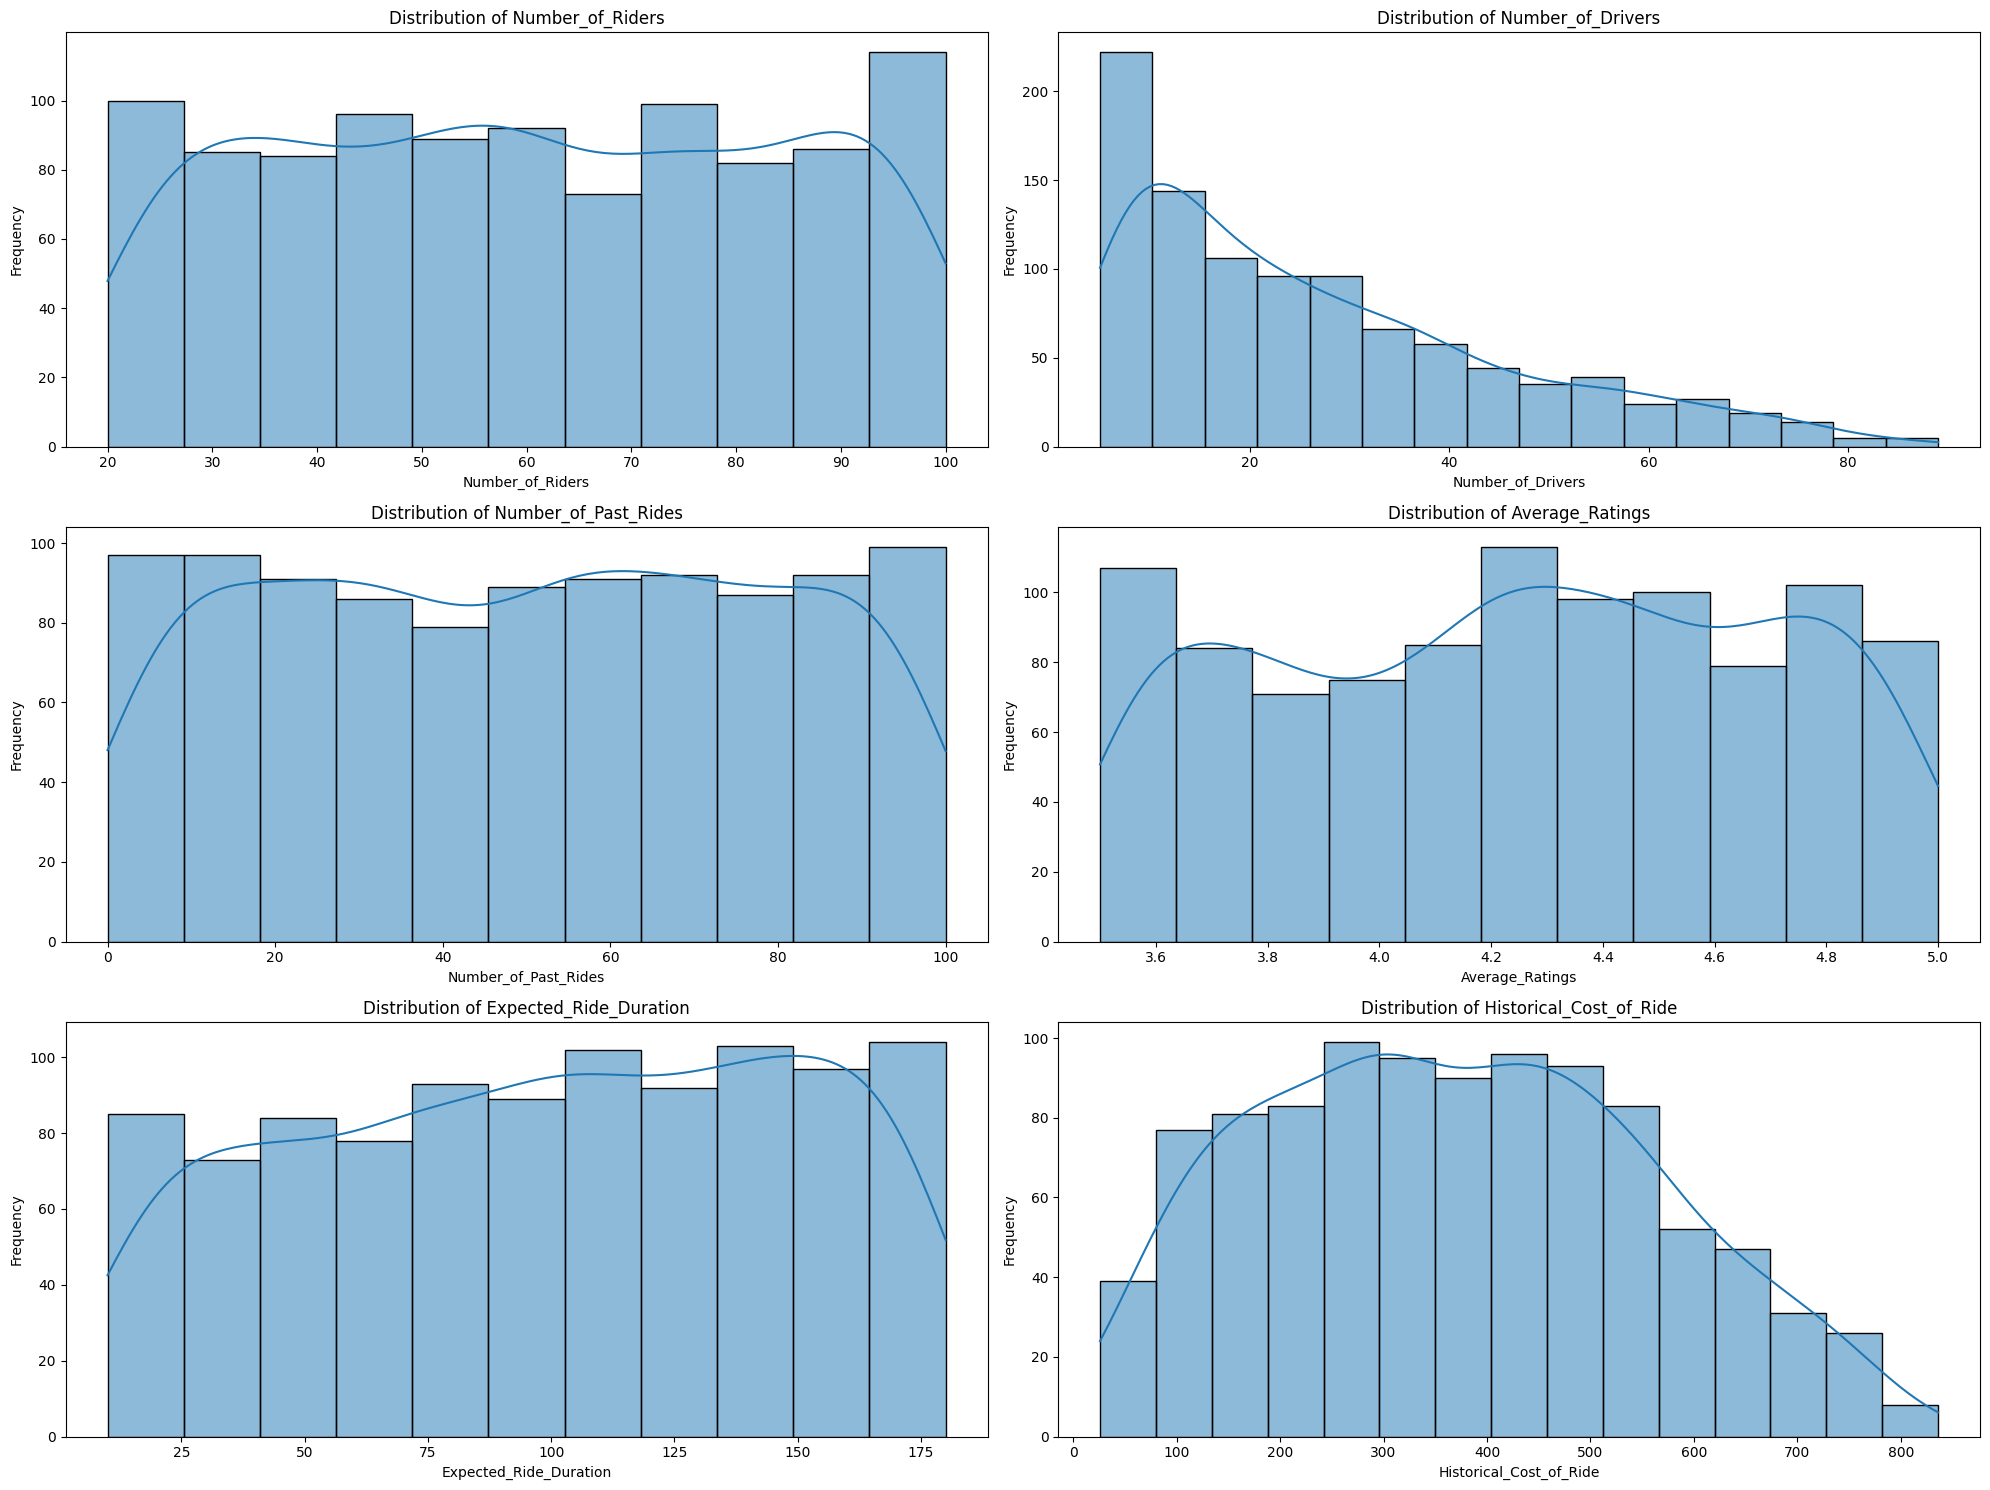

In [6]:
# Determine the layout of subplots
n_cols = 2
n_rows = len(numerical_cols) // n_cols + (len(numerical_cols) % n_cols > 0)

# Create a figure and a grid of subplots
plt.figure(figsize=(20, 5 * n_rows))

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
df[numerical_cols].describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


Ahora, las categóricas:

In [8]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

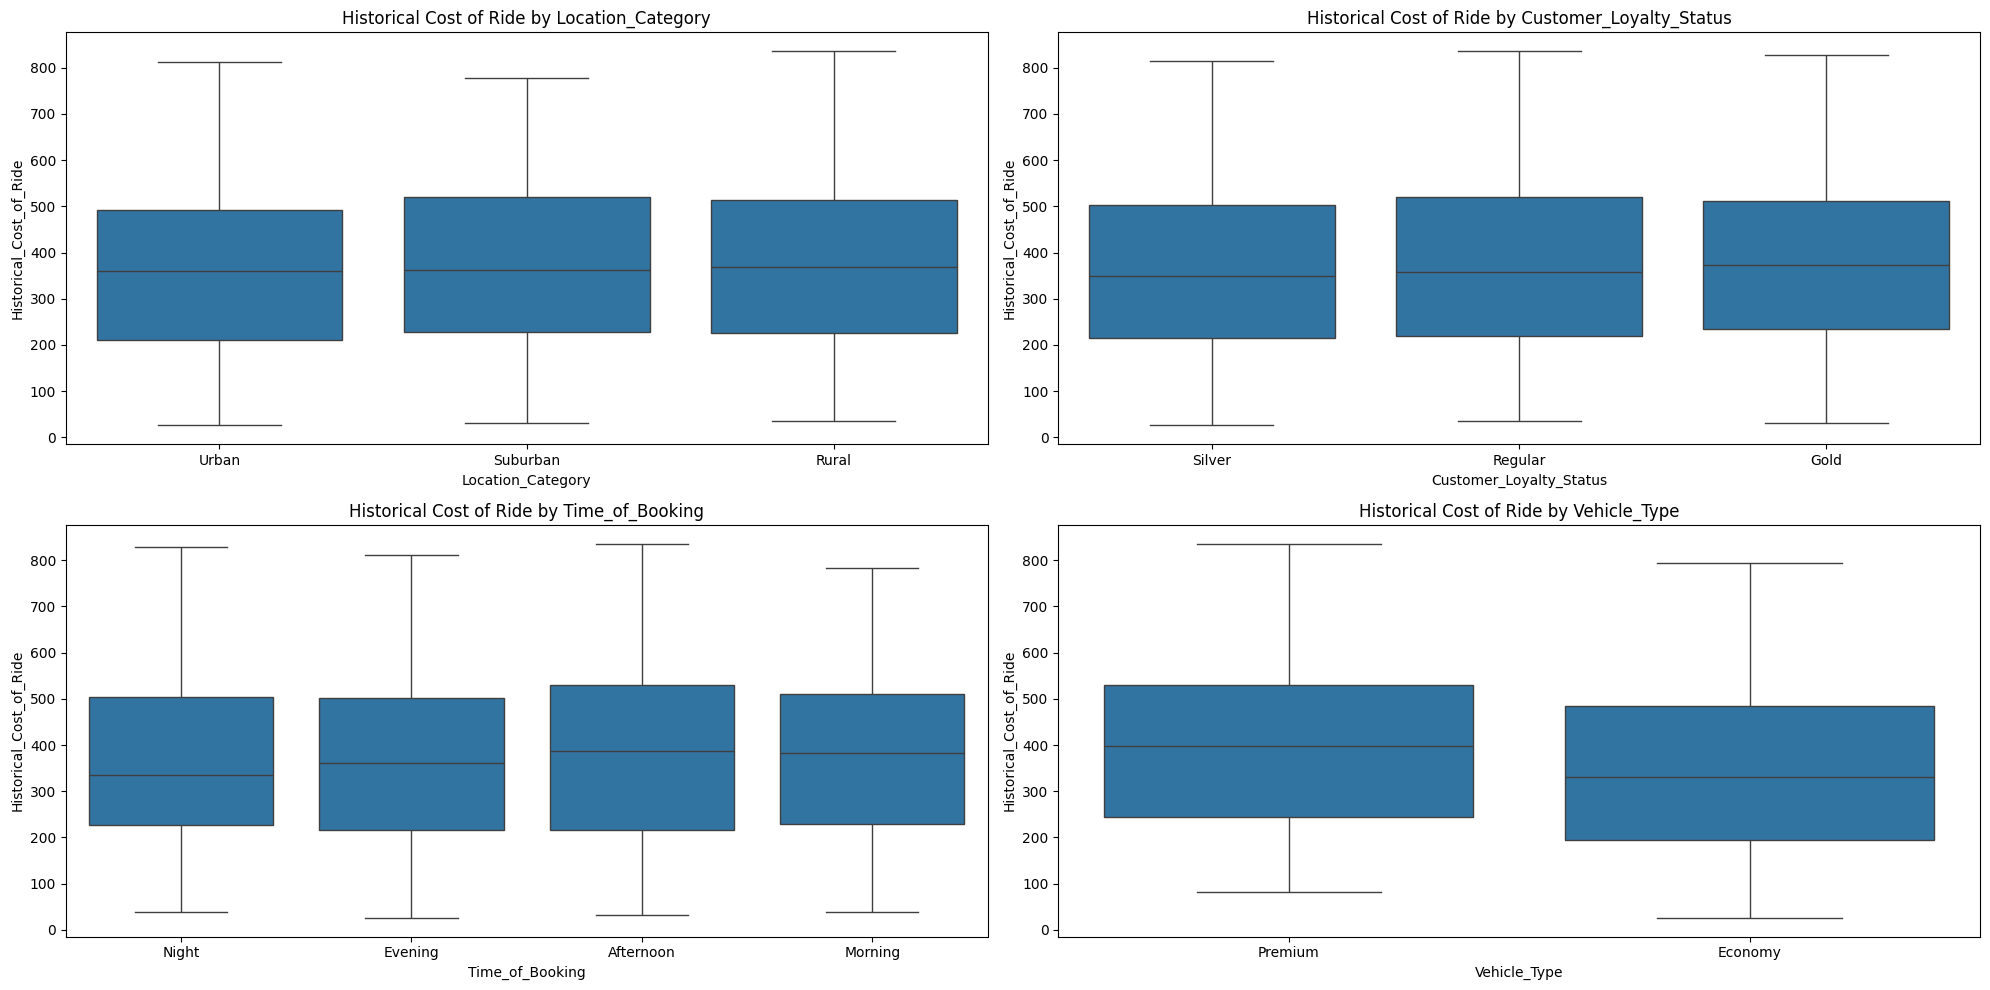

In [9]:
n_rows = len(categorical_cols) // n_cols + (len(categorical_cols) % n_cols > 0) 

plt.figure(figsize=(20, 5 * n_rows))

for i, column in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=column, y='Historical_Cost_of_Ride', data=df)
    plt.title(f'Historical Cost of Ride by {column}')

plt.tight_layout()
plt.show()

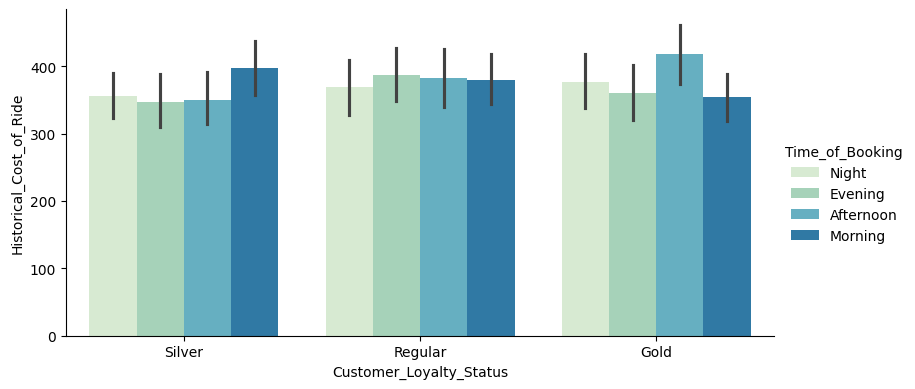

In [10]:
sns.catplot(data=df, x="Customer_Loyalty_Status", y="Historical_Cost_of_Ride", hue="Time_of_Booking", kind="bar", height=4, aspect=2, palette= 'GnBu')
plt.show()

#### Preprocesamiento

Vamos a normalizar (estrategia Min-Max) las variables numéricas y codificar las variables categóricas:

In [11]:
# Creating transformers for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fitting the preprocessor and transforming the dataset
df_scaled = preprocessor.fit_transform(df)

# Getting feature names for the transformed dataset
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

# Converting the processed array back to a dataframe
df_scaled = pd.DataFrame(df_scaled, columns=feature_names)

# Display the processed dataframe
df_scaled.head()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
0,0.8750,0.476190,0.13,0.646667,0.470588,0.318796,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.4750,0.404762,0.72,0.373333,0.194118,0.182542,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.2750,0.309524,0.00,0.326667,0.388235,0.375007,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.8625,0.273810,0.67,0.540000,0.729412,0.548321,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.7250,0.202381,0.74,0.180000,0.817647,0.683462,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Observemos la matrix de correlación:

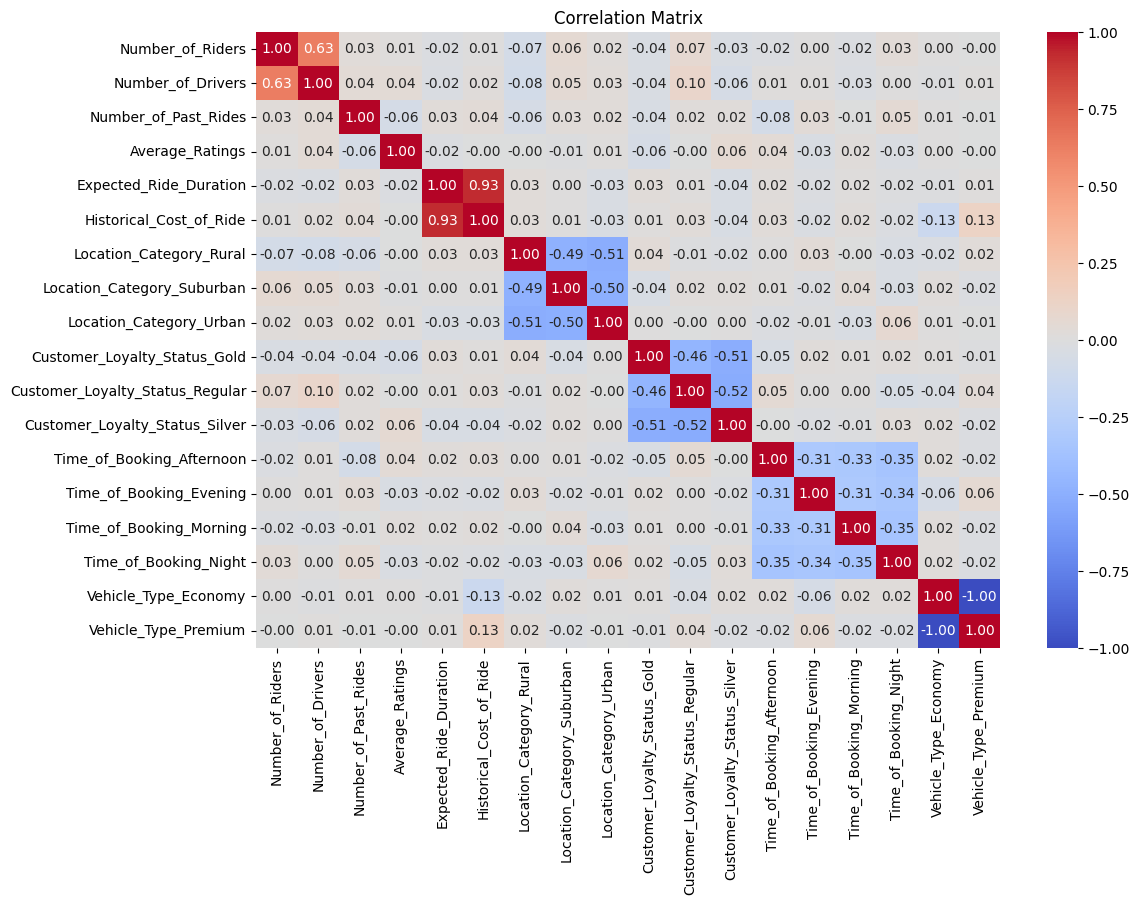

In [12]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

En este caso, no haremos feature selection, aunque si podriamos entre Expected_Ride_Duration y Historical_Cost_of_Ride, lo cual parece bastante lógico.

### Q-Learning y Bellman: Algoritmo de aprendizaje

![RL](./Images/rl.jpg)

El algoritmo Q-learning es un método de aprendizaje por refuerzo que permite a un agente aprender a tomar decisiones óptimas para alcanzar un objetivo en un entorno determinado. Q-Learning fue introducido por Chris Watkins en 1989. Watkins y Peter Dayan presentaron una prueba de convergencia en 1992.

El objetivo del Q-learning es aprender una política de acciones que maximice la suma total de recompensas recibidas a lo largo del tiempo.

**Componentes principales del Q-learning:**

* **Agente:** Entidad que aprende a tomar decisiones basadas en el estado del entorno.
* **Entorno:** El mundo con el que interactúa el agente, que incluye estados y recompensas.
* **Estados:** Representaciones del entorno en un momento dado.
* **Acciones:** Las diferentes operaciones que el agente puede realizar en el entorno.
* **Recompensas:** Valor que el agente recibe después de tomar una acción en un estado específico, indicando el éxito o fracaso de esa acción.

Funcionamiento del Q-learning:

1) **Inicialización:** Se crea una tabla Q inicializada con ceros (o valores aleatorios pequeños), donde las filas representan los estados y las columnas las acciones. Los valores Q representan la calidad de una acción específica tomada en un estado específico.

2) **Interacción con el entorno:** En cada episodio de entrenamiento, el agente toma acciones en el entorno, observa las recompensas recibidas y actualiza los valores Q en la tabla Q basándose en esas recompensas y las estimaciones futuras de recompensas.

3) **Política de acción:** El agente utiliza una política (como ε-greedy) para explorar el entorno tomando acciones aleatorias con una probabilidad ε o explotar el conocimiento actual eligiendo la acción con el mayor valor Q para el estado actual con una probabilidad de 1-ε. Esto equilibra la exploración de nuevas acciones con la explotación de acciones conocidas que maximizan las recompensas.

4) **Actualización de la tabla Q:** Después de cada acción, la tabla Q se actualiza utilizando la ecuación de actualización de Q-learning:

$Q(s,a)_{new}=Q(s,a)+α[r+γ max_{a^′}​Q(s^′,a^′)−Q(s,a)]$

Donde:

* $Q(s,a)$: El valor Q actual para el estado $s$ y la acción $a$.
* $α$: Tasa de aprendizaje.
* $r$: Recompensa recibida por tomar la acción $a$ en el estado $s$.
* $γ$: Factor de descuento para las recompensas futuras.
* $max⁡_{a′}Q(s^′,a^′)$: La mejor estimación de valor Q para el próximo estado $s^′$.

![Q-equation](./Images/Qequation.png)

**Convergencia:**

Con suficiente interacción y actualización, la tabla Q converge hacia los valores óptimos, permitiendo que el agente tome las mejores decisiones para maximizar las recompensas totales a lo largo del tiempo.

El Q-learning es un algoritmo poderoso y flexible para el aprendizaje por refuerzo que no requiere un modelo del entorno, lo que lo hace adecuado para una amplia gama de aplicaciones, desde juegos hasta problemas de decisión en entornos complejos y dinámicos.

Veamos como encarar esto:

**Estados**

El estado debe encapsular la situación actual que podría afectar a las decisiones de fijación dinámica de precios. Un estado completo podría ser una combinación de las siguientes características:

* Location_Category: Categórica (Urbana, Suburbana, Rural)
* Customer_Loyalty_Status: Categórico (Normal, Plata, Oro)
* Time_of_Booking: Categórica (Mañana, Tarde, Noche)
* Vehicle_Type: Categórico (Económico, Premium)

**Acciones**

Las acciones pueden implicar el establecimiento de diferentes niveles de precios. Para simplificar, podemos definir las acciones como ajustes del precio base:

* Aumentar el precio en un porcentaje determinado (por ejemplo, 10%, 20%)
* Disminuir el precio en un porcentaje determinado (por ejemplo, 10%, 20%)
* Mantener el precio sin cambios

**Recompensas**

La estructura de recompensas podría basarse en maximizar el beneficio manteniendo o mejorando la satisfacción del cliente. Una recompensa sencilla podría definirse del siguiente modo:

* Recompensa positiva por un viaje reservado al precio ajustado, modificada además por el estado de fidelidad del cliente (mayores recompensas para los clientes fieles).
* Recompensa negativa si no se produce ninguna reserva en un plazo determinado tras el ajuste de precios.
* Recompensas adicionales por mantener o mejorar la valoración media dentro de una categoría de viajes.

**Implementación**

Dada esta configuración, el algoritmo de aprendizaje profundo Q aprenderá iterativamente la mejor acción (ajuste de precios) a tomar en cada estado (condiciones actuales del mercado) para maximizar la recompensa a largo plazo (beneficio y satisfacción del cliente). Todo esto a traves de una red neuronal que encapsula la lógica.

Empecemos simplificando y codificando las características para definir los estados, y luego podremos simular un entorno de aprendizaje Q para optimizar la estrategia de precios. Debido a la complejidad de la fijación dinámica de precios en tiempo real, nuestra simulación será un modelo simplificado.

In [13]:
df

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422
...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.21,Morning,Premium,11,91.389526
996,84,29,Urban,Regular,92,4.55,Morning,Premium,94,424.155987
997,44,6,Suburban,Gold,80,4.13,Night,Premium,40,157.364830
998,53,27,Suburban,Regular,78,3.63,Night,Premium,58,279.095048


In [14]:
df_scaled

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
0,0.8750,0.476190,0.13,0.646667,0.470588,0.318796,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.4750,0.404762,0.72,0.373333,0.194118,0.182542,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.2750,0.309524,0.00,0.326667,0.388235,0.375007,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.8625,0.273810,0.67,0.540000,0.729412,0.548321,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.7250,0.202381,0.74,0.180000,0.817647,0.683462,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.1625,0.214286,0.24,0.473333,0.005882,0.080724,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
996,0.8000,0.285714,0.92,0.700000,0.494118,0.491484,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
997,0.3000,0.011905,0.80,0.420000,0.176471,0.162162,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
998,0.4125,0.261905,0.78,0.086667,0.282353,0.312424,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Para simular el entorno e implementar el algoritmo DQ-learning para la fijación dinámica de precios, seguiremos los siguientes pasos:

* Simular el entorno: Definir una función que simule la respuesta del mercado a diferentes acciones de fijación de precios. Esta función proporcionará recompensas basadas en la acción realizada en un estado determinado.

* Calcular la recompensa: Defina una función de recompensa que calcule la recompensa por tomar una determinada acción en un estado específico, considerando factores como la satisfacción del cliente y el margen de beneficio.

* Implementar DQ-Learning: Configurar el algoritmo Q-learning, incluyendo la inicialización de la tabla Q, la definición de la tasa de aprendizaje (alfa), el factor de descuento (gamma), y la estrategia de exploración (por ejemplo, epsilon-greedy).

In [22]:
def simulate_environment(state_idx, action, state_df, eps=1e-3):
    """
    Revenue-based simulator using normalized features, with guards against
    division by zero or nan. Uses precomputed Rider_Driver_Ratio_Norm directly.
    """
    row = state_df.iloc[state_idx]
    
    # 1) Fetch normalized base price, ensure it's not zero
    base_p = float(row['Historical_Cost_of_Ride'])
    base_price = max(base_p, eps)  # avoid zero
    
    # 2) Apply action to get new price
    if action == 0:
        price = base_price * 0.9   # 10% discount
    elif action == 2:
        price = base_price * 1.1   # 10% surcharge
    else:
        price = base_price         # hold
    
    # 3) Use normalized supply–demand ratio
    drivers = float(row['Number_of_Drivers'])+ 1e-6 # avoid zero
    riders = float(row['Number_of_Riders'])
    ratio = float(riders/drivers) 

    # 4) Build logits and probability, clipping to [0,1]
    logits = (price / base_price - 1) * 5 - (ratio - 1) * 3
    prob_book = 1 / (1 + np.exp(logits))
    prob_book = np.clip(prob_book, 0.0, 1.0)
    
    # 5) Return normalized revenue if booked, else 0
    return price if np.random.rand() < prob_book else 0.0

### Deep Q-Learning

![DQN](./Images/dqn.png)

In [24]:
# --- 1. a simple Pricing Environment
class PricingEnv:
    def __init__(self, state_df, simulate_fn, max_steps=100):
        self.state_df = state_df
        self.simulate = simulate_fn
        self.n_states = len(state_df)
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.current_step = 0
        self.current_state = np.random.randint(self.n_states)
        return self.state_df.iloc[self.current_state].values.astype(np.float32)

    def step(self, action):
        reward = self.simulate(self.current_state, action, self.state_df)
        self.current_state = np.random.randint(self.n_states)
        next_state = self.state_df.iloc[self.current_state].values.astype(np.float32)
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return next_state, reward, done, {}

In [25]:
# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [26]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.vstack(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buffer)

In [27]:
# DQN Agent
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        device="gpu" if torch.cuda.is_available() else "cpu",
        buffer_size=10000,
        batch_size=4,
        gamma=0.99,
        lr=1e-4,
        soft_update=False,
        tau=1e-3,

    ):
        self.device = torch.device(device)
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.AdamW(self.q_net.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.soft_update = soft_update
        self.epsilon = 1
        self.eps_min = 0.01
        self.eps_decay = 0.99995

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.q_net.layers[-1].out_features)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return int(q_values.argmax(dim=1).item())

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Current Q estimates
        q_values = self.q_net(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(dim=1, keepdim=True)[0]
            q_targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Loss and backward
        loss = nn.MSELoss()(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update of target network
        if self.soft_update:
            for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
        else:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay epsilon
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)

        return loss.item()  

In [28]:
# --- 2. Instantiate environment and agent ---
env = PricingEnv(df_scaled, simulate_environment, max_steps=50)
state_dim = df_scaled.shape[1]
action_dim = 3  # decrease, hold, increase

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, device=device)

In [31]:
# --- 3. Training loop ---
episodes = 2000
episode_rewards, losses = [], []
best_avg_reward = -np.inf
pbar = trange(episodes, desc="Training")
for ep in pbar:
    state, done = env.reset(), False
    ep_reward = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.push(state, action, reward, next_state, done)
        loss = agent.update()
        if loss is not None:
            losses.append(loss)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)

    # Compute rolling average
    avg100 = np.mean(episode_rewards[-100:])

    # Save best model based on rolling average reward
    if avg100 > best_avg_reward:
        best_avg_reward = avg100
        torch.save(agent.q_net.state_dict(), 'best_model.pt')
        pbar.write(f"New best model saved at ep {ep} with avg100={avg100:.2f}")

    # Periodic checkpoint every 1000 episodes
    if (ep + 1) % 1000 == 0:
        torch.save(agent.q_net.state_dict(), f"dqn_ep{ep+1}.pt")
        pbar.write(f"Checkpoint saved at ep {ep+1}")

    # update the tqdm bar to show current reward & epsilon
    pbar.set_postfix({
        "ep_reward": f"{ep_reward:.1f}",
        "avg100":    f"{np.mean(episode_rewards[-100:]):.1f}",
        "eps":       f"{agent.epsilon:.3f}"
    })
print("Training complete.")

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

New best model saved at ep 0 with avg100=15.03
New best model saved at ep 1 with avg100=17.26
New best model saved at ep 2 with avg100=17.67
New best model saved at ep 3 with avg100=17.83
Checkpoint saved at ep 1000
Checkpoint saved at ep 2000
Training complete.


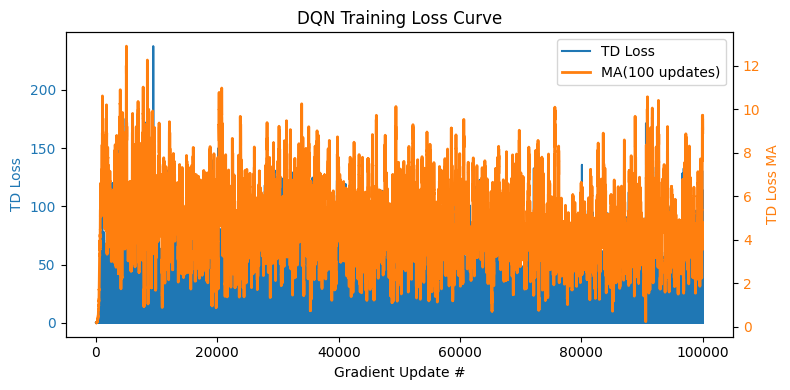

In [47]:
# Create main figure and axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot raw TD loss on first y-axis
ax1.plot(losses, color='tab:blue', label='TD Loss')
ax1.set_ylabel("TD Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(
    pd.Series(losses).rolling(100).mean(), 
    color='tab:orange',
    linewidth=2, 
    label="MA(100 updates)"
)
ax2.set_ylabel("TD Loss MA", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and x-label
plt.title("DQN Training Loss Curve")
ax1.set_xlabel("Gradient Update #")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

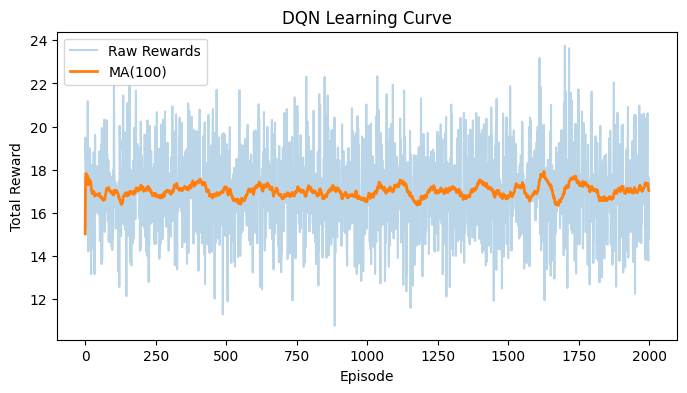

In [74]:
# Convert to a Series
sr = pd.Series(episode_rewards)

# Compute rolling mean (using at least 1 period so we never divide by zero)
smoothed = sr.rolling(window=50, min_periods=1).mean()

plt.figure(figsize=(8,4))
plt.plot(sr,       alpha=0.3, label="Raw Rewards")
plt.plot(smoothed, linewidth=2, label="MA(100)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Learning Curve")
plt.legend()
plt.show()

Pregunta: Que esta pasando?

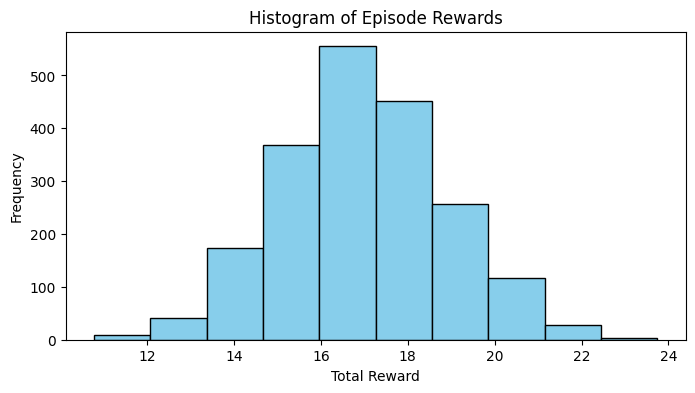

In [53]:
# Plot the histogram of episode rewards
plt.figure(figsize=(8, 4))
plt.hist(episode_rewards, color='skyblue', edgecolor='black')
plt.title("Histogram of Episode Rewards")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.show()

### Inferencia

In [54]:
# Create a fresh agent
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, device=device)

# Load
checkpoint_path = "best_model.pt"
state_dict = torch.load(checkpoint_path, map_location=device)
agent.q_net.load_state_dict(state_dict)

# Synchronize the target network
agent.target_net.load_state_dict(agent.q_net.state_dict())

# Set networks to evaluation mode (disables dropout, etc.)
agent.q_net.eval()
agent.target_net.eval()

QNetwork(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [55]:
# Calculate the total revenue, total rides, and average revenue per ride based on historical data
total_revenue_historical = df['Historical_Cost_of_Ride'].sum()
total_rides_historical = df.shape[0]
average_revenue_per_ride_historical = total_revenue_historical / total_rides_historical if total_rides_historical > 0 else 0

In [56]:
print(f"Total Revenue: ${total_revenue_historical:.3f}, Total Rides: {total_rides_historical}, Average Revenue per Ride: ${average_revenue_per_ride_historical:.2f}")

Total Revenue: $372502.623, Total Rides: 1000, Average Revenue per Ride: $372.50


In [57]:
def evaluate_dqn(agent, env, num_steps=1000):
    """
    Runs the trained DQN agent for a fixed number of steps and
    returns (total_revenue, total_rides, avg_revenue_per_ride).
    """
    total_revenue, total_rides = 0.0, 0
    state = env.reset()
    
    for _ in range(num_steps):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        # Only count it as a ride if it booked
        if reward > 0:
            total_revenue += reward
            total_rides   += 1
            print(f"Accepted ride: action={action}, reward={reward:.2f}")
        
        state = next_state
        if done:
            state = env.reset()

    return total_revenue, total_rides

In [58]:
# disable exploration for evaluation
agent.epsilon = 0.0

In [59]:
# find the index of your price column in numerical_cols
scaler: MinMaxScaler = preprocessor.named_transformers_['num']
price_idx = numerical_cols.index('Historical_Cost_of_Ride')

# raw‐data min/max (in USD)
min_price = scaler.data_min_[price_idx]
max_price = scaler.data_max_[price_idx]

print(f"Raw Historical_Cost_of_Ride ranges from ${min_price:.2f} to ${max_price:.2f}")

Raw Historical_Cost_of_Ride ranges from $25.99 to $836.12


In [84]:
# Evaluate the trained DQN agent ---
total_revenue_dqn, total_rides_dqn = evaluate_dqn(agent, env, num_steps=1000)

Accepted ride: action=1, reward=0.27
Accepted ride: action=2, reward=0.13
Accepted ride: action=1, reward=0.38
Accepted ride: action=1, reward=0.56
Accepted ride: action=0, reward=0.59
Accepted ride: action=2, reward=0.69
Accepted ride: action=2, reward=0.61
Accepted ride: action=2, reward=0.63
Accepted ride: action=0, reward=0.38
Accepted ride: action=1, reward=0.36
Accepted ride: action=1, reward=0.66
Accepted ride: action=2, reward=0.33
Accepted ride: action=2, reward=0.12
Accepted ride: action=0, reward=0.38
Accepted ride: action=2, reward=0.65
Accepted ride: action=1, reward=0.54
Accepted ride: action=2, reward=0.89
Accepted ride: action=1, reward=0.47
Accepted ride: action=1, reward=0.65
Accepted ride: action=1, reward=0.02
Accepted ride: action=0, reward=0.44
Accepted ride: action=1, reward=0.17
Accepted ride: action=1, reward=0.56
Accepted ride: action=2, reward=0.67
Accepted ride: action=2, reward=0.51
Accepted ride: action=1, reward=0.49
Accepted ride: action=1, reward=0.19
A

In [85]:
total_revenue_dqn, total_rides_dqn

(344.2855686352753, 767)

In [86]:
# Inverse Norm
total_revenue_dqn = total_revenue_dqn * (max_price - min_price) + min_price

In [87]:
# Calculate average revenue per ride
average_revenue_per_ride_dqn = total_revenue_dqn / total_rides_dqn if total_rides_dqn > 0 else 0 

In [88]:
# Construct comparison DataFrame ---
comparison_data = {
    "Metric": ["Total Revenue", "Total Rides", "Average Revenue per Ride"],
    "Historical Data": [
        total_revenue_historical,
        total_rides_historical,
        average_revenue_per_ride_historical
    ],
    "Deep Q-Learning": [
        total_revenue_dqn,
        total_rides_dqn,
        average_revenue_per_ride_dqn
    ]
}

comparison_df = pd.DataFrame(comparison_data)

In [89]:
# Format numeric columns for presentation ---
def format_value(metric, value):
    if metric == "Total Rides":
        return int(value)
    else:
        return f"${value:,.2f}"

comparison_df["Historical Data"] = comparison_df.apply(
    lambda row: format_value(row["Metric"], row["Historical Data"]), axis=1
)
comparison_df["Deep Q-Learning"] = comparison_df.apply(
    lambda row: format_value(row["Metric"], row["Deep Q-Learning"]), axis=1
)

In [90]:
comparison_df

,Metric,Historical Data,Deep Q-Learning
0,Total Revenue,"$372,502.62","$278,939.64"
1,Total Rides,1000,767
2,Average Revenue per Ride,$372.50,$363.68


De la comparación entre los resultados de DQ-learning y los datos históricos se desprende que el modelo Q-learning, en su aplicación actual, no ha mejorado los ingresos totales. Hay que tener en cuenta algunos puntos a la hora de interpretar estos resultados:

* Simplificación del modelo: El modelo Q-learning actual y la simulación del entorno están simplificados. No se tienen en cuenta factores del mundo real como el comportamiento de los clientes, los precios de la competencia y acontecimientos externos (como vacaciones o condiciones meteorológicas) que podrían afectar significativamente a la demanda y a las estrategias de precios.

* Ajuste de parámetros: El rendimiento del aprendizaje DQ depende en gran medida del ajuste de parámetros como la tasa de aprendizaje, el factor de descuento, la tasa de exploración (épsilon) y la tasa de decaimiento de épsilon o demas hiperparametros de la red. El ajuste de estos parámetros puede dar lugar a resultados diferentes.

* Representación de características y espacio de estados: La forma en que se definen y codifican los estados puede tener un impacto sustancial en el proceso de aprendizaje. Considerar características más detalladas o ajustar la forma en que se categorizan las características podría mejorar la capacidad del modelo para aprender estrategias eficaces de fijación de precios.

* Función de recompensa: El diseño de la función de recompensa desempeña un papel fundamental a la hora de guiar el proceso de aprendizaje. La simulación de recompensa actual es básica y podría no captar todos los matices de la satisfacción del cliente y la rentabilidad.

* Exploración vs. Explotación: El equilibrio entre la exploración de nuevas acciones y la explotación de estrategias conocidas es crucial. Es posible que el modelo actual no haya explorado suficientes alternativas o haya explotado acciones subóptimas debido a la estrategia de decaimiento épsilon.


### Ejercicio

* Mejorar el agente DQN para calibrarse con los datos.

* Entrenar un agente Q-learning para maximizar la recompensa de la simulación considerando los puntos anteriores. 
Empezar por lo más simple (Parameter Fine-Tunning) a estrategias más complejas y reales de estados, acciones y recompensas.

### Referencias

* A Beginners Guide to Q-Learning: https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c

* Knowledge transfer in Reinforcement Learning ...can RL be a little easier?: https://regressionist.github.io/2019-05-13-Reinforcement-Learning/

* Deep Q Learning: https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae

#### Artículos de interés

* DeepMind AI Reduces Google Data Centre Cooling Bill by 40%: https://deepmind.google/discover/blog/deepmind-ai-reduces-google-data-centre-cooling-bill-by-40/

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)